# Thông tin thành viên
- **Họ và tên:** Nguyễn Chí Cường &nbsp; **MSSV:** &nbsp; 21120422
- **Họ và tên:**  ê Hữu Hưng &nbsp; **MSSV:** &nbsp;  21120463

# 1. Import thư viện

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# Native bayes
from sklearn.naive_bayes import MultinomialNB

# Decision tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import time

[nltk_data] Downloading package stopwords to C:\Users\FPT
[nltk_data]     SHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\FPT
[nltk_data]     SHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\FPT
[nltk_data]     SHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Preprocessing data

In [2]:
# train.csv: https://drive.google.com/file/d/1r04nzjrVx15b-GBhRcsr80wm-AXkEdo_/view?usp=sharing
# val.csv: https://drive.google.com/file/d/1NkaTbBpHdUhcereL7Nhv6NQHhPCLOtWy/view?usp=sharing

### Tải file train.csv và val.csv ===> Nếu chạy trên google colab thì uncomment
# !gdown 'https://drive.google.com/uc?id=1r04nzjrVx15b-GBhRcsr80wm-AXkEdo_' -O train.csv
# !gdown 'https://drive.google.com/uc?id=1NkaTbBpHdUhcereL7Nhv6NQHhPCLOtWy' -O val.csv

In [3]:
### Đọc file CSV và đặt cột "Message ID" làm index, sau đó bỏ qua các cột không cần thiết
### Lưu ý: Nếu chạy trên jupyter notebook thì có file train.csv và val.csv cùng thư mục code
train_data = pd.read_csv('train.csv', index_col='Message ID').drop(columns=['Unnamed: 0', 'split'], axis=1)
val_data = pd.read_csv('val.csv', index_col='Message ID').drop(columns=['Unnamed: 0', 'split'], axis=1)

In [4]:
# Hiển thị 5 dòng đầu tiên trong tập train
train_data.head()

,Subject,Message,Spam/Ham
Message ID,,,
0,christmas tree farm pictures,NaN,ham
1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,re : issue,fyi - see note below - already done .\nstella\...,ham
5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham


In [5]:
# Hiện thị 5 dòng đầu tiên trong tập val
val_data.head()

,Subject,Message,Spam/Ham
Message ID,,,
23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham
24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham
32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham
37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham
43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham


In [6]:
# Hiển thị số lượng sample trong tập train và val
print('Number of rows of train data: ', len(train_data))
print('Number of rows of val data',len(val_data))

Number of rows of train data:  27284
Number of rows of val data 3084


Number of spam email of train data:  13858
Number of ham email of train data:  13426
Number of spam email of val data:  1563
Number of ham email of val data:  1521


D:\Save\anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


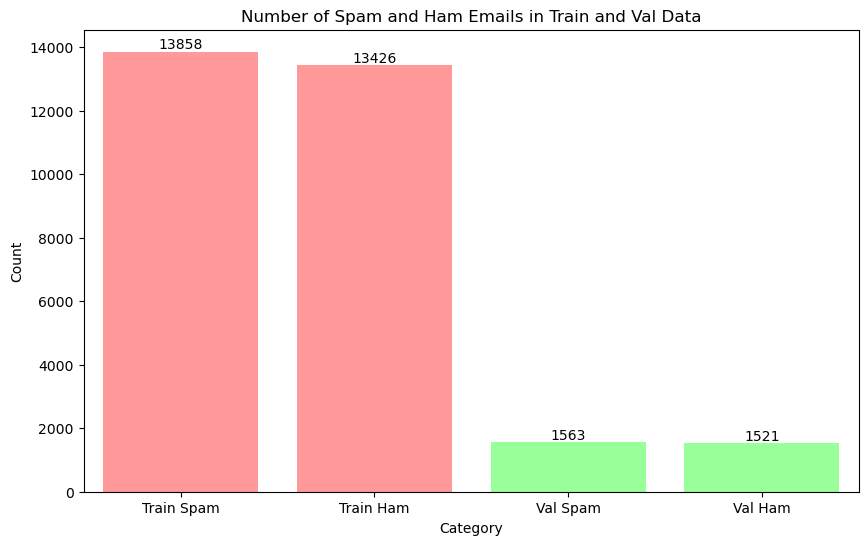

In [7]:
# Tính toán số lượng nhãn spam và ham trong tập train và val
train_spam_count = len(train_data[train_data['Spam/Ham'] == 'spam'])
train_ham_count = len(train_data[train_data['Spam/Ham'] == 'ham'])
val_spam_count = len(val_data[val_data['Spam/Ham'] == 'spam'])
val_ham_count = len(val_data[val_data['Spam/Ham'] == 'ham'])

print('Number of spam email of train data: ',train_spam_count )
print('Number of ham email of train data: ',train_ham_count)
print('Number of spam email of val data: ', val_spam_count)
print('Number of ham email of val data: ', val_ham_count)

# Tạo dữ liệu trong đồ thị
labels = ['Train Spam', 'Train Ham', 'Val Spam', 'Val Ham']
counts = [train_spam_count, train_ham_count, val_spam_count, val_ham_count]

# Vẽ đồ thị (graph)
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=counts)

# Chỉnh màu
colors = ['#ff9999', '#ff9999', '#99ff99', '#99ff99']
for i, patch in enumerate(plt.gca().patches):
    patch.set_facecolor(colors[i])

# Thêm title và nhãn cho đồ thị (graph)
plt.title('Number of Spam and Ham Emails in Train and Val Data')
plt.xlabel('Category')
plt.ylabel('Count')

# Hiện thị số lượng trên mỗi cột
for i in range(len(counts)):
    plt.text(i, counts[i] + 0.5, counts[i], ha='center', va='bottom')

# Hiện thị
plt.show()

In [8]:
# Xóa những dòng trùng lặp
train_data.drop_duplicates(inplace=True)
val_data.drop_duplicates(inplace=True)

len(train_data), len(val_data)

# Nhận xét: Có những dòng trùng lặp nào trong tập train và val

(25023, 3033)

In [9]:
# Kiểm tra tỷ lệ giá trị NaN trong train và val
print("Train.csv:\n", train_data.isna().sum(), "\n\n")
print("Val.csv:\n",val_data.isna().sum())

Train.csv:
 Subject     159
Message     236
Spam/Ham      0
dtype: int64 


Val.csv:
 Subject     25
Message     29
Spam/Ham     0
dtype: int64


In [10]:
# Thay thế giá trị NaN trong train và val thành chuỗi rỗng
train_data = train_data.fillna('')
val_data = val_data.fillna('')

In [11]:
# Trích xuất nội dung của 1 sample: Subject và Message để quan sát dữ liệu
# train_data['Subject'][1], train_data['Message'][1]

In [12]:
%%time
# Hàm tiền xử lý văn bản
def clean_text(text):
    """
    1. Chuyển thành chữ thường
    2. Tách từ (tokenization)
    3. Xóa các ký tự đặc biệt
    # 4. Xóa stop words - không cần thiết vì dùng cho tf-idf
    5. Lemmatization
    6. Nối từ thành chuỗi
    """
    # 1. Chuyển chữ thường
    text = text.lower()

    # 2. Tách từ (tokenization)
    words = word_tokenize(text)

    # 3. Xóa kí tự đặc biệt
    regex = r'[^a-zA-Z0-9\s]'
    words = [re.sub(regex, '', word) for word in words]

    # # 4. Xóa stop words - không cần thiết vì dùng cho tf-idf
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]

    # 5. Lemmatization (Đưa từ về gốc)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # 6. Nối lại các từ thành chuỗi
    return ' '.join(words)

# Áp dụng hàm clean_text cho dữ liệu train và val
def apply_clean_text(data, columns):
    for column in columns:
        data[column] = data[column].apply(clean_text)
    return data

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
# Tiền xử lý cho tập train và tập val
train_data = apply_clean_text(train_data, ['Subject', 'Message'])
val_data = apply_clean_text(val_data, ['Subject', 'Message'])

# Kiểm tra kết quả đầu ra sau khi tiền xử lý tập train
train_data.head()

,Subject,Message,Spam/Ham
Message ID,,,
0,christmas tree farm picture,,ham
1,vastar resource inc,gary production from the high island larger b...,ham
2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham
3,re issue,fyi see note below already done stella ...,ham
5,mcmullen gas for 11 99,jackie since the inlet to 3 river plant is sh...,ham


In [14]:
# Kiểm tra kết quả đầu ra sau khi tiền xử lý tập val
val_data.head()

,Subject,Message,Spam/Ham
Message ID,,,
23,miscellaneous,forwarded by ami chokshi...,ham
24,re purge of old contract event status,fyi what do you all think ...,ham
32,valero 8018 and 1394,it is my understanding the outage valero incur...,ham
37,01 00 natural gas nomination,enron methanol company nominates the following...,ham
43,re misc question,forwarded by ami chokshi...,ham


In [15]:
# Gán lại nhãn cho spam và ham
train_data['Spam/Ham'] = train_data['Spam/Ham'].map({'spam': 1, 'ham': 0})
val_data['Spam/Ham'] = val_data['Spam/Ham'].map({'spam': 1, 'ham': 0})

In [16]:
train_data.head()

,Subject,Message,Spam/Ham
Message ID,,,
0,christmas tree farm picture,,0
1,vastar resource inc,gary production from the high island larger b...,0
2,calpine daily gas nomination,calpine daily gas nomination 1 doc,0
3,re issue,fyi see note below already done stella ...,0
5,mcmullen gas for 11 99,jackie since the inlet to 3 river plant is sh...,0


In [17]:
%%time
# Vector hóa Subject và Message
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)

train_data['combined_text'] = train_data['Subject'] + " " + train_data['Message']
val_data['combined_text'] = val_data['Subject'] + " " + val_data['Message']

X_train_tfidf = vectorizer.fit_transform(train_data['combined_text'])
y_train = train_data['Spam/Ham']

# Lấy tập val làm tập để test mô hình
X_val_tfidf = vectorizer.transform(val_data['combined_text'])
y_val = val_data['Spam/Ham']


CPU times: total: 2.81 s
Wall time: 5.1 s


# 3. Model

In [18]:
# Hàm huấn luyện và đánh giá mô hình một mô hình
def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, param_grid=None):
    start_time = time.time()

    # Khảo sát siêu tham số
    if param_grid:
        print(f" === Khảo sát siêu tham số mô hình {model_name} sử dụng GridSearchCV ...")
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_  # Lấy mô hình với siêu tham số tốt nhất
        print(f"  Tham số tốt nhất của {model_name}: {grid_search.best_params_}")
    else:
        # Huấn luyện mô hình mà không khảo sát siêu tham số
        model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_val)

    # Đánh giá mô hình
    accuracy = accuracy_score(y_val, y_pred)
    # print(f"  {model_name} Accuracy: {accuracy:.2f}")
    # print(classification_report(y_val, y_pred))

    # Tính thời gian huấn luyện
    training_time = time.time() - start_time
    # print(f"  Training time: {training_time:.2f} seconds")

    return model, accuracy, training_time

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hàm huấn luyện và đánh giá nhiều mô hình
def train_and_evaluate_multimodel(model_dict, X_train, y_train, X_val, y_val):
    # Dictionary lưu trữ kết quả đánh giá của các mô hình
    results = {}

    # Duyệt qua từng mô hình trong dictionary
    for model_name, model_info in model_dict.items():
        model = model_info['model']  # Lấy mô hình
        param_grid = model_info.get('param_grid', None)  # Lấy param_grid (nếu có)

        print(f"\n===== Huấn luyện và đánh giá {model_name} model =====")

        # Gọi hàm train_and_evaluate_model cho từng mô hình
        best_model, accuracy, training_time = train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, param_grid)

        # Lưu kết quả vào dictionary
        results[model_name] = {
            'best_model': best_model,
            'accuracy': accuracy,
            'training_time': training_time
        }

    return results

# Hàm vẽ confusion matrix
def plot_confusion_matrix(cm, model_name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [20]:
model_dict = {
    "Naive Bayes": {
        'model': MultinomialNB(),
        # 'param_grid': {
        #     'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        # }
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier(random_state=42),
        # 'param_grid': {
        #     'max_depth': [None, 10, 20, 30],
        #     'criterion': ['gini', 'entropy']
        # }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        # 'param_grid': {
        #     'n_estimators': [100, 200],
        #     'max_depth': [None, 10, 20]
        # }
    },
    "SVM": {
        'model': SVC(random_state=42),
        # 'param_grid': {
        #     'C': [0.1, 1, 10],
        #     'kernel': ['linear', 'rbf']
        # }
    }
}

# Huấn luyện và đánh giá các mô hình
results = train_and_evaluate_multimodel(model_dict, X_train_tfidf, y_train, X_val_tfidf, y_val)

# In kết quả
for model_name, result in results.items():
    print(f"{model_name} - Accuracy: {result['accuracy']:.4f}, Training Time: {result['training_time']:.2f} seconds")



===== Huấn luyện và đánh giá Naive Bayes model =====

===== Huấn luyện và đánh giá Decision Tree model =====

===== Huấn luyện và đánh giá Random Forest model =====

===== Huấn luyện và đánh giá SVM model =====
Naive Bayes - Accuracy: 0.9763, Training Time: 0.02 seconds
Decision Tree - Accuracy: 0.9644, Training Time: 14.85 seconds
Random Forest - Accuracy: 0.9878, Training Time: 31.03 seconds
SVM - Accuracy: 0.9871, Training Time: 139.66 seconds


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hàm vẽ confusion matrix cho từng mô hình
def plot_confusion_matrices(results, X_val, y_val):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Chuyển ma trận 2D thành 1D để dễ dàng index

    for i, (model_name, result) in enumerate(results.items()):
        best_model = result['best_model']  # Lấy mô hình tốt nhất
        y_pred = best_model.predict(X_val)  # Dự đoán trên tập validation

        # Tạo confusion matrix
        cm = confusion_matrix(y_val, y_pred)

        # Vẽ confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"{model_name} Confusion Matrix")
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các biểu đồ
    plt.show()

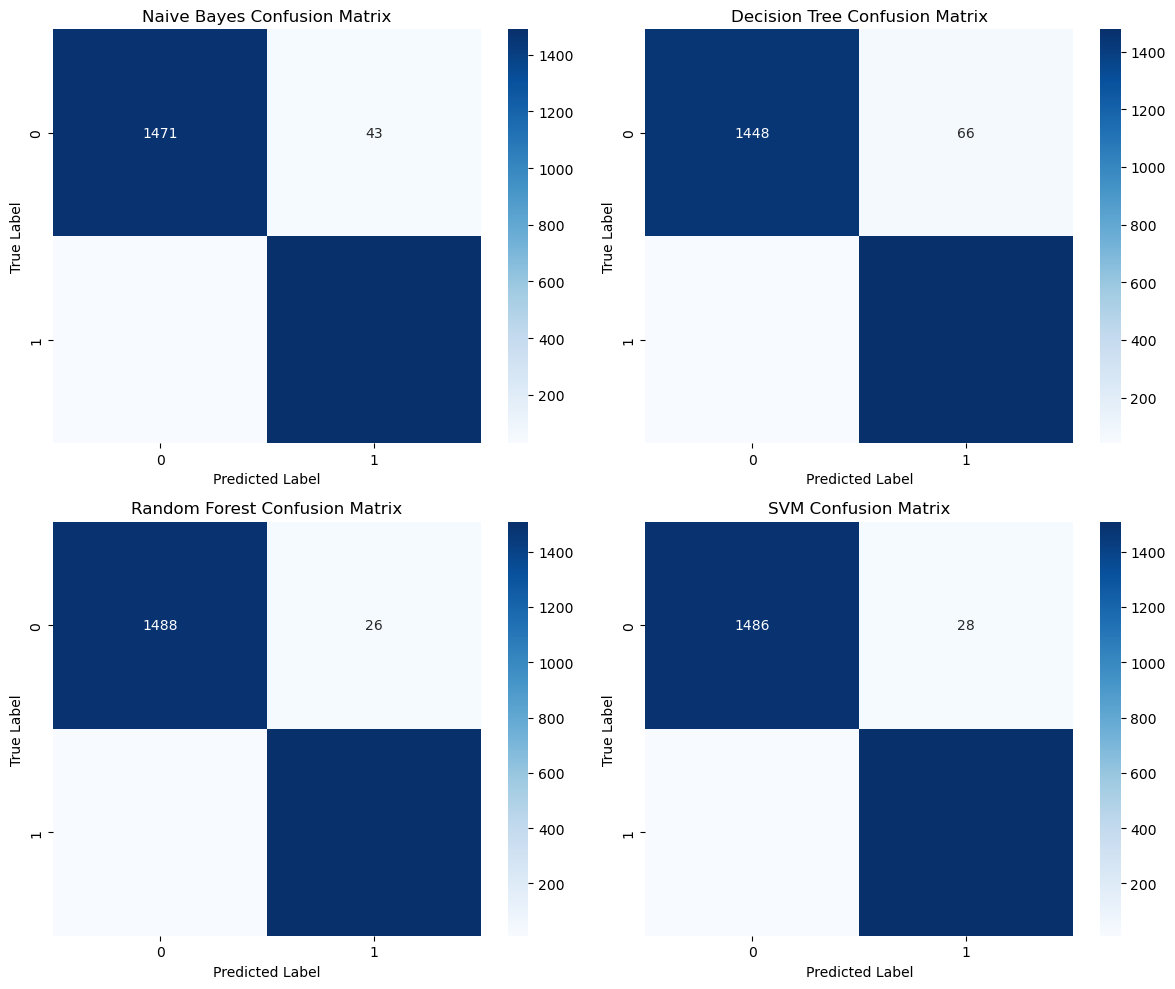

In [22]:
# Ví dụ gọi hàm với kết quả sau khi huấn luyện 4 mô hình
plot_confusion_matrices(results, X_val_tfidf, y_val)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Hàm vẽ biểu đồ so sánh accuracy và thời gian huấn luyện của các mô hình
def plot_model_comparison(results):
    """
    Hàm này nhận vào kết quả sau khi huấn luyện các mô hình,
    và vẽ biểu đồ so sánh accuracy và training time (đường cho thời gian, cột cho accuracy).

    results: Dictionary chứa các thông tin của mô hình như accuracy và training_time
    """
    # Tách tên mô hình, accuracy và thời gian huấn luyện từ kết quả
    model_names = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in model_names]
    training_times = [results[model]['training_time'] for model in model_names]

    # Thiết lập chiều rộng của các cột trong biểu đồ
    bar_width = 0.4
    index = np.arange(len(model_names))  # Vị trí của các mô hình trên trục X

    # Tạo figure và các subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Vẽ biểu đồ cột cho accuracy
    bars = ax1.bar(index, accuracies, bar_width, label='Accuracy', color='b')

    # Thiết lập thông tin cho trục X và tiêu đề
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy', color='b')
    ax1.set_title('Model Comparison: Accuracy and Training Time')

    # Gắn tên các mô hình vào trục X
    ax1.set_xticks(index)
    ax1.set_xticklabels(model_names)

    # Hiển thị giá trị accuracy trên đầu cột
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', color='b')

    # Vẽ biểu đồ đường cho training time
    ax2 = ax1.twinx()  # Tạo một trục Y thứ hai để vẽ đường cho thời gian huấn luyện
    ax2.plot(index, training_times, color='r', marker='o', label='Training Time', linewidth=2)
    ax2.set_ylabel('Training Time (seconds)', color='r')

    # Hiển thị giá trị thời gian tại các điểm trên đường
    for i, time in enumerate(training_times):
        ax2.text(i, time, f'{time:.2f}', ha='center', va='bottom', color='r')

    # Hiển thị legend (chú thích)
    ax1.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.05))

    # Điều chỉnh layout để không bị trùng lặp các thành phần
    plt.tight_layout()
    plt.subplots_adjust(top=1.2)
    plt.show()

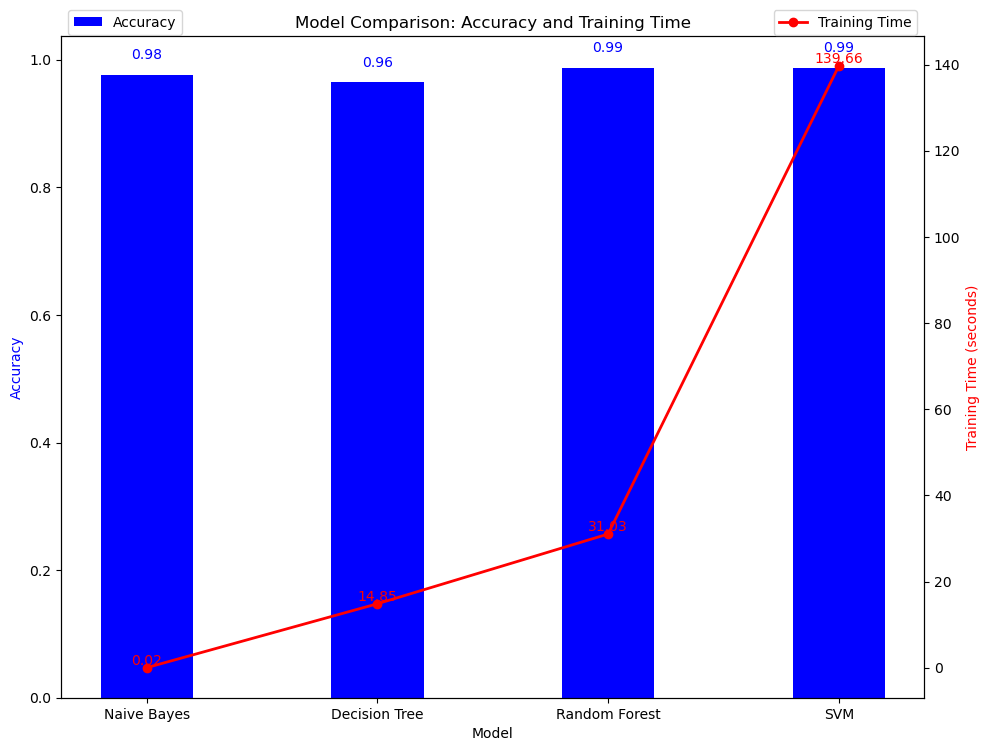

In [24]:
plot_model_comparison(results)

In [25]:
# Lưu model vào My drive
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
# import pickle

# # Lưu mô hình vào thư mục drive
# pickle.dump(results['Naive Bayes']['best_model'], open('/content/drive/MyDrive/data_model_lab1/nb_model_param.pkl', 'wb'))
# pickle.dump(results['Decision Tree']['best_model'], open('/content/drive/MyDrive/data_model_lab1/dt_model_param.pkl', 'wb'))
# pickle.dump(results['Random Forest']['best_model'], open('/content/drive/MyDrive/data_model_lab1/rf_model_param.pkl', 'wb'))
# pickle.dump(results['SVM']['best_model'], open('/content/drive/MyDrive/data_model_lab1/svm_model_param.pkl', 'wb'))

## Link tham khảo:
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/svm.html

https://aman.ai/primers/ai/word-vectors/#term-frequency-inverse-document-frequency-tf-idf